In [325]:
import sys
import network as netfn
import seaborn as sns
import os
import glob
from matplotlib import pyplot as plt
import numpy as np
import plot as pltfn
from sklearn.cluster import KMeans
plt.style.use('dark_background')
%load_ext autoreload
%autoreload

# Define paths
#---------------------------------------------------------------------------
Fdrop = '/Users/dominicburrows/Dropbox/PhD/analysis/'
Fmac = '/Users/dominicburrows/Documents/'
F10t = '/Volumes/Dominic 10tb/'
Ffig = '/Users/dominicburrows/Dropbox/PhD/figures/'
Ftm = '/Volumes/Dominic Time Machine/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Create coordlist 
#If realcoord file has 5 columns & kcoord has 3 = ALREADY CLUSTERED
#---------------------------------------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
coordlist = sorted(glob.glob('*realcoord.npy'))
tracelist = sorted(glob.glob('*realtrace.npy'))
ktrace = sorted(glob.glob('*ktrace.npy'))
kcoord = sorted(glob.glob('*kcoord.npy'))
tracelist

# Node parcellation

In [ ]:
# Run k-mean clustering on x-y coordinates to get spatially contiguous seed clusters
#Re-saves coordinate file with spacek labels as new columns (realcoord, 4columns: x,y,z,spacek labels)
#-----------------------------------------------------------------------------------------
kmeans = netfn.spacek(coordlist, Fdrop, experiment, mcc = 10)

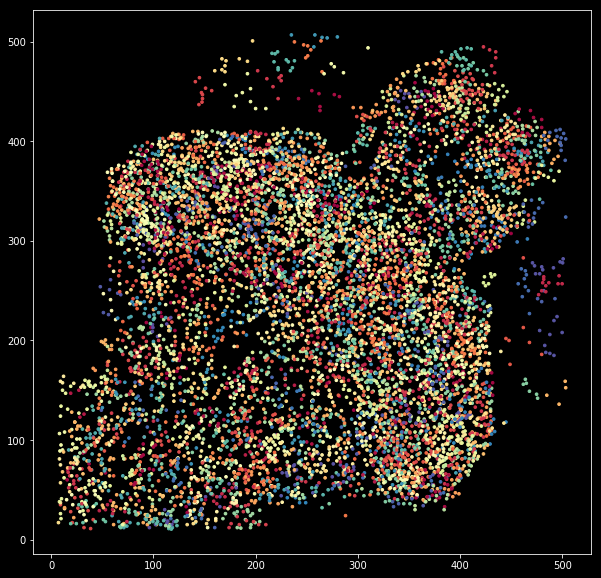

In [330]:
# Plot an illustrative example
#----------------------------------------------------------------------------------------
fish = 2
# Pull out the data from fish structure
#----------------------------------------------------------------------------------------
cs = np.load(coordlist[fish])
x = cs[:,0]
y = cs[:,1]
# Actual plotting routines
#----------------------------------------------------------------------------------------
plt.figure(figsize = (10,10))
plt.scatter(x, y, s = 7, c = cs[:,3],  cmap = 'Spectral', alpha = 1)
plt.show()

## Functional clusters

In [ ]:
# Calculate average traces within clusters
# Saves - array of traces for each spatial cluster (ktrace) and 
# mean coords for each cluster(kcoords, 3columns: x,y,z)
#run - define whether this is the first time doing average or second
#------------------------------------------------------------------------------
Fktrace, Fkcoord  = netfn.average(Fdrop, experiment, tracelist, coordlist)

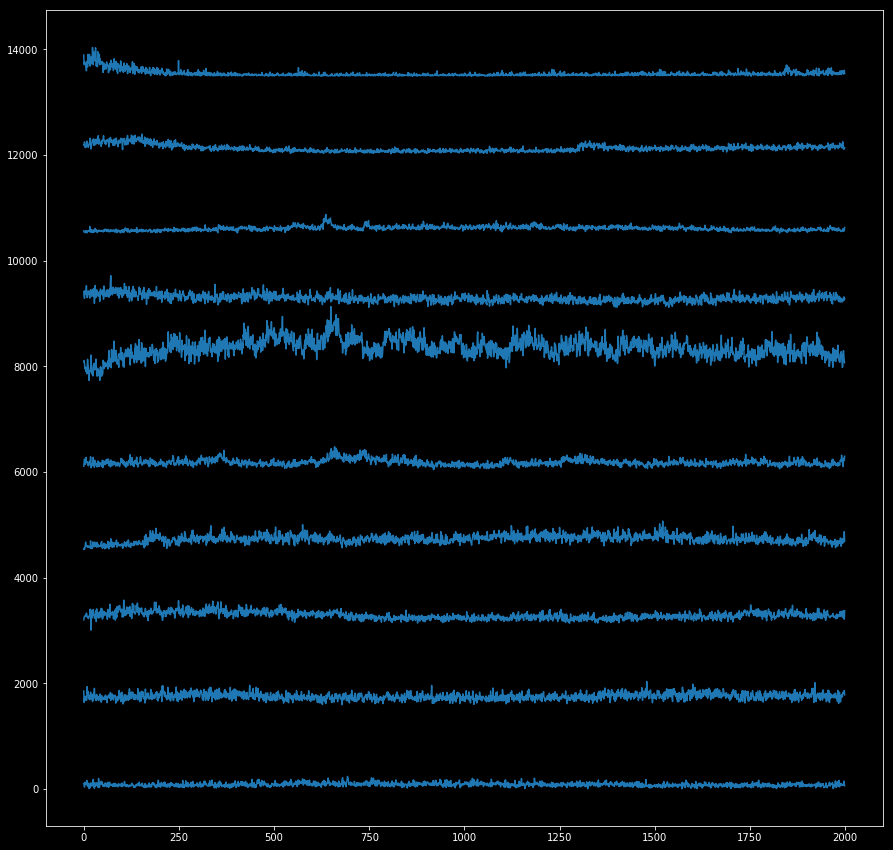

In [337]:
# Plot an example traces
#----------------------------------------------------------------------------------------------
nplt  = 10
fish = 2
d     = np.load(ktrace[0])[:nplt,:2000]
cm    = plt.get_cmap("Paired")

plt.figure(figsize=(15,15))
for i in range(nplt):
    plt.plot(d[i,:] + 1500*i, c=cm(1))

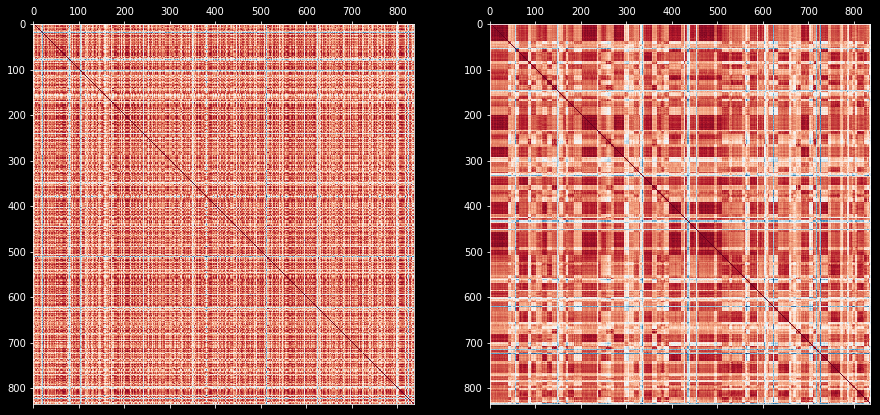

In [340]:
# Plot correlation spatial clusters and functional/spatial clusters
#---------------------------------------------------------------------------------
fish = 2
cor = np.corrcoef(np.load(ktrace[fish])) #correlation matrix of each spatial cluster
kmeans   = KMeans(n_clusters=100, random_state=0).fit(cor) #spatial clusters clustered on functional correlation
kl       = kmeans.labels_ #new labels for functional clusters
klstd   = np.argsort(kl) #returns indices that would sort each spatial cluster into new cluster
scor    = cor[klstd,:]
scor    = scor[:,klstd] #re-order correlation matrix
fig, ax = plt.subplots(1,2, figsize= (15,10))
ax[0].matshow(cor, cmap='RdBu_r')
ax[1].matshow(scor, cmap='RdBu_r')
plt.show()

In [ ]:
#Run K-means clustering on correlation matrix
#Re-saves - kcoord file by appending functional cluster labels 
#(4columns: x,y,z, correlation cluster label)
#-----------------------------------------------------------
Fkcorr = netfn.funck(Fdrop, experiment, ktrace, kcoord)

In [ ]:
# Split up clusters according to spatial parameters
#Re-saves - kcoord file by appending functional cluster labels
#(5columns: x,y,z, corr cluster label, re-assigned corr cluster label)
#-----------------------------------------------------------------------
for i in range(len(kcoord)):
    kread = np.load(kcoord[i]) 
    nkl = netfn.divconq(kcoord, i, Fdrop, experiment, kcoord[i], kread)
    newclusterar = np.column_stack((kread[:,:4],nkl))
    np.save(Fdrop + 'Project/' + experiment + os.sep + kcoord[i][:kcoord[i].find('run')+6] + '_kcoord.npy', newclusterar)

In [ ]:
#Re-average traces and coords according to new parcel labels
#Re-saves ktrace and kcoord file (3 columns = x,y,z) and appends final label values to realcoord file (5 columns)
#-----------------------------------------------------------------------------
for y in range(len(kcoord)):
    cs = np.load(coordlist[y])[:,:4] #single neuron coordinates
    ks = np.load(kcoord[y])[:,4] #final cluster labels
    labelvec = np.zeros(cs.shape[0])
    for i in range(cs.shape[0]):
        labelvec[i] = np.int(ks[np.int(cs[:,3][i])])
    finalcoord = np.column_stack((cs,labelvec))
    np.save(Fdrop + 'Project/' + experiment + os.sep + coordlist[y][:coordlist[y].find('run')+6] + '_' + 'realcoord.npy', finalcoord)
Fktrace, Fkcoord  = netfn.average(Fdrop, experiment, tracelist, coordlist = coordlist)

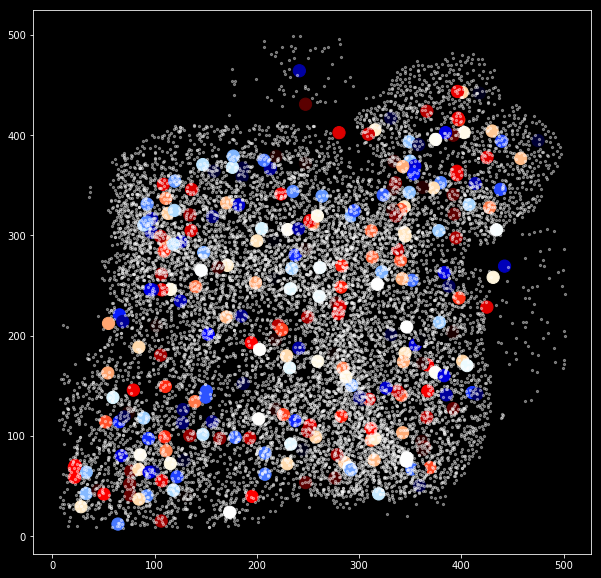

In [351]:
# PLOT - final nodes
#----------------------------------------------------------------------------------------
fish = 1
# Pull out the data from fish structure
#----------------------------------------------------------------------------------------
cs = np.load(kcoord[fish])
cs1 = np.load(coordlist[fish])
x = cs[:,0]
x1 = cs1[:,0]
y = cs[:,1]
y1 = cs1[:,1]
# Actual plotting routines
#----------------------------------------------------------------------------------------
plt.figure(figsize = (10,10))
plt.scatter(x, y, s = 150, c = x,  cmap = 'flag', alpha = 1)
plt.scatter(x1, y1, s = 5,  c = 'w', alpha = 0.4)
plt.show()

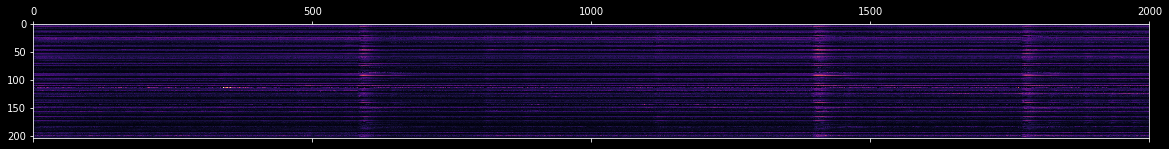

In [256]:
# Plot example module traces
#---------------------------------------------------------------------------------------
fish = 5
fig, ax = plt.subplots(1, figsize= (20,5))
ax.matshow(np.load(ktrace[fish])[:,:2000], cmap='magma')
plt.show()

# Module detection

In [ ]:
# Convert matrix into NetworkX Graph object to run module detection
#-------------------------------------------------------------------------------------
cor        = np.corrcoef(Fish["Parcels"]["Data"]); 
cor[cor < 0] = 0
G          = nx.from_numpy_array(cor)
partition  = community.best_partition(G)
M          = {"Label":np.asarray(partition.values())}
Fish.update({"Modules":M})

# Network topology

In [416]:
# Create network list
#-----------------------------------------------
experiment = 'PTZ-WILDTYPE'
os.chdir(Fdrop + 'Project/' + experiment)
ktrace = sorted(glob.glob('*ktrace.npy'))
kcoord = sorted(glob.glob('*kcoord.npy'))
ktrace

['PTZ-WILDTYPE-01_2photon_sess-01-6dpf_BLN_run-01_ktrace.npy',
 'PTZ-WILDTYPE-01_2photon_sess-01-6dpf_PTZ05_run-01_ktrace.npy',
 'PTZ-WILDTYPE-01_2photon_sess-01-6dpf_PTZ20_run-01_ktrace.npy',
 'PTZ-WILDTYPE-02_2photon_sess-01-6dpf_BLN_run-01_ktrace.npy',
 'PTZ-WILDTYPE-02_2photon_sess-01-6dpf_PTZ05_run-01_ktrace.npy',
 'PTZ-WILDTYPE-02_2photon_sess-01-6dpf_PTZ20_run-01_ktrace.npy',
 'PTZ-WILDTYPE-03_2photon_sess-01-6dpf_BLN_run-01_ktrace.npy',
 'PTZ-WILDTYPE-03_2photon_sess-01-6dpf_PTZ05_run-01_ktrace.npy',
 'PTZ-WILDTYPE-03_2photon_sess-01-6dpf_PTZ20_run-01_ktrace.npy',
 'PTZ-WILDTYPE-04_2photon_sess-01-6dpf_BLN_run-01_ktrace.npy',
 'PTZ-WILDTYPE-04_2photon_sess-01-6dpf_PTZ05_run-01_ktrace.npy',
 'PTZ-WILDTYPE-04_2photon_sess-01-6dpf_PTZ20_run-01_ktrace.npy',
 'PTZ-WILDTYPE-05_2photon_sess-01-6dpf_BLN_run-01_ktrace.npy',
 'PTZ-WILDTYPE-05_2photon_sess-01-6dpf_PTZ05_run-01_ktrace.npy',
 'PTZ-WILDTYPE-05_2photon_sess-01-6dpf_PTZ20_run-01_ktrace.npy',
 'PTZ-WILDTYPE-06_2photon_sess-01-6

## Closed cycles

/Users/dominicburrows/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


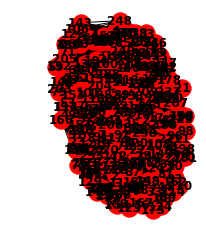

In [381]:
plt.subplot(121)
nx.draw(G, with_labels=True, font_weight='bold')
#nx.draw_shell(G, nlist=[range(5, 10), range(5)], with_labels=True, font_weight='bold')

In [ ]:
allfcyclist

In [417]:
steps = 10

allfcyclist = list(range(len(kcoord)))
for y in range(len(kcoord)):
    trace = np.load(ktrace[y])
    cyclist = list(range(steps))
    index = 0
    for cutoff in range(1, steps+1):

        # Network construction
        #=====================================================================
        # Calculate correlation coefficient
        #---------------------------------------------------------------------
        A = np.corrcoef(trace) #correlation matrix of ktraces
        np.fill_diagonal(A, 0) #fills diagonal with 0s (removes self correlation)
    
        # Z-score and binarise according to z cut off
        #---------------------------------------------------------------------
        # A  = stats.zscore(np.ravel(A)).reshape(A.shape)
        bA = A > (cutoff / 10)
    
        # Generate Network x object GRAPH
        #---------------------------------------------------------------------
        G = nx.from_numpy_matrix(bA) #generates graph connected edges between nodes only above threshold correlation

        # Calculate cycle density
        #=====================================================================
        cycs = nx.algorithms.cycle_basis(G) #returns list of complete cycles in data
        no_E = G.number_of_edges() #how many edges in network
        if no_E > 0: ncd = len(nx.algorithms.cycle_basis(G)) / no_E
        else:        ncd = 0
        
        cyclist[index] = ncd
        index+=1
    allfcyclist[y] = cyclist
    

In [ ]:
swp = np.zeros((3,10))
ai  = 0
for a in arange:
    swp[0,ai] = np.mean(a[0:9])
    swp[1,ai] = np.mean(a[10:19])
    swp[2,ai] = np.mean(a[20:])
        
    ai = ai + 1

In [ ]:
plt.plot(np.transpose(swp))